# Homework 3
**Submitted by: Soumik Ghosh**

## Task 1: Algorithmic Analysis of K-Means Clustering with Real World Dataset

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib as mpl

import seaborn as sns
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from IPython.display import Image
init_notebook_mode(connected=True)
%matplotlib inline

import surprise
from surprise import KNNBasic
from surprise.model_selection import GridSearchCV
from surprise import Reader
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import KNNWithMeans


First, download a simulated dataset: kmeans_data.zip from Modules->Datasets. Then, 
implement the K-means algorithm from scratch. K-means algorithm computes the distance of a 
given data point pair. Replace the distance computation function with Euclidean distance, 1- 
Cosine similarity, and 1 – the Generalized Jarcard similarity (refer to: 
https://www.itl.nist.gov/div898/software/dataplot/refman2/auxillar/jaccard.htm). 

In [2]:
X = pd.read_csv("./kmeans_data/data.csv")
Y = pd.read_csv("./kmeans_data/label.csv")


In [3]:
X

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.658,0.659,0.660,0.661,0.662,0.663,0.664,0.665,0.666,0.667
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
Y

,7
0,2
1,1
2,0
3,4
4,1
...,...
9994,2
9995,3
9996,4
9997,5


The K-Means Algorithm from scratch along with Euclidean distance, Cosine similarity, and the Generalized Jaccard similarity. 

```py
import concurrent.futures

def lists_equal(a, b):
    return np.array_equal(np.sort(a), np.sort(b))

#distance computation function with Euclidean distance
def euclidean(a, b):
    return np.sqrt(np.sum(np.square(np.subtract(a, b))))

#distance computation function with cosine similarity
def cosine(a, b):
    return 1 - np.divide(np.sum(np.multiply(a, b)),
                         np.multiply(np.sqrt(np.sum(np.square(a))),
                                     np.sqrt(np.sum(np.square(b)))))

#distance computation function with jaccard distance
def jaccard(a, b):
    return 1 - np.divide(np.sum(np.minimum(a, b)),
                         np.sum(np.maximum(a, b)))


def SSE(distance_function, X, centroids):
    result = 0
    for centroid in centroids:
        for point in X:
            result += distance_function(centroid, point)**2
    return result


def accuracy(Y, computed_Y):
    cluster_score = []
    for i in range(len(Y)):
        cluster_score.insert(i, [])
        for j in range(len(Y)):
            cluster_score[i].insert(j, 0)
    
    for i in range(len(Y)):
        cluster_score[computed_Y[i]][Y[i][0]] += 1
    
    correct = 0
    total = 0
    for i in range(len(Y)):
        winner = 0
        max_seen = 0
        for j in range(len(Y)):
            if cluster_score[i][j] > max_seen:
                winner = j
                max_seen = cluster_score[i][j]
                
        for j in range(len(Y)):
            total += cluster_score[i][j]
            if j == winner:
                correct += cluster_score[i][j]
    return correct / total


def Kmeans(distance_func, X, Y=[], K=0, centroids=np.array([]), stoppers=["Centroid unchanged"],
           maxIterations=0, task_id=""):

    if task_id == "stopper":
        ret = str(distance_func.__name__) + "\t" + str(stoppers) + "\n"
    else:
        ret = str(distance_func.__name__) + "\n"
   
    computed_Y = np.full(X.shape[0], 0)
   
    if len(stoppers) < 1 and maxIterations == 0:
        print("Missing stop criteria.")
        return
  
    if centroids.size > 0:

        if len(centroids) != K:
            print("Mismatch Found " + str(centroids) +
                  "Initial centroids with K = " + str(K))
 
    else:
        centroids = X[np.random.choice(X.shape[0], K, replace=False), :]

    start = time.time_ns()
    iterations = 0
    while True:

        old_centroids = np.copy(centroids)
        iterations += 1

        tmp_centroid_sum = np.zeros(centroids.shape)
        tmp_centroid_count = np.zeros(centroids.shape[0])
    
        for point_idx, point in enumerate(X):
            shortest_distance = float('inf')
  
            for centroid_idx, centroid in enumerate(centroids):
                distance = distance_func(point, centroid)
                if distance < shortest_distance:
                    shortest_distance = distance

                    computed_Y[point_idx] = centroid_idx

            tmp_centroid_sum[computed_Y[point_idx]] = np.add(
                tmp_centroid_sum[computed_Y[point_idx]], point)

            tmp_centroid_count[computed_Y[point_idx]] += 1

        for i in range(len(centroids)):

            if tmp_centroid_count[i] == 0:
                print("A centroid was found empty at iteration " + str(iterations))

                centroids[i] = np.copy(old_centroids[i])
            else:

                centroids[i] = np.divide(tmp_centroid_sum[i],
                                         np.full(centroids.shape[1], tmp_centroid_count[i]))

        if "Centroid unchanged" in stoppers and lists_equal(old_centroids, centroids):
            break #when there is no change in centroid position
           
        if "SSE" in stoppers and SSE(distance_func, X, centroids) \
                > SSE(distance_func, X, old_centroids):

            centroids = np.copy(old_centroids)
            break #when the SSE value increases in the next iteration

        if (maxIterations != 0 and iterations >= maxIterations) \
                or (maxIterations == 0 and iterations >= 500):
            break #when the maximum preset value (e.g., 500, here) of iteration is complete

    end = time.time_ns()

    if task_id == "task1":
        ret += "SSE = " + str(SSE(distance_func, X, centroids)) + "\n"
        ret += "Predictive accuracy = " + str(accuracy(Y, computed_Y))
    if task_id == "stopper":
        ret += str(iterations) + "\t" + str(SSE(distance_func, X, centroids)) \
            + "\t" + str(end - start) + " nsec"
    return ret


def main():

    X = pd.read_csv("./Kmeans_data/data.csv")
    Y = pd.read_csv("./Kmeans_data/label.csv")
    X = X.to_numpy(dtype=float)
    Y = Y.to_numpy(dtype=int)

  
    with concurrent.futures.ProcessPoolExecutor(max_workers=24) as executor:
        
        futures = []

        #Task 1.1 and 1.2
        futures.append(executor.submit(
            Kmeans, euclidean, X, Y=Y, K=10, task_id="task1"))
        futures.append(executor.submit(
            Kmeans, cosine, X, Y=Y, K=10, task_id="task1"))
        futures.append(executor.submit(
            Kmeans, jaccard, X, Y=Y, K=10, task_id="task1"))

        #Task 1.3
        futures.append(executor.submit(Kmeans, euclidean, X, Y=Y,
                       K=10, maxIterations=500, stoppers=["Centroid unchanged", "SSE"], task_id="stopper"))
        futures.append(executor.submit(Kmeans, cosine, X, Y=Y,
                       K=10, maxIterations=500, stoppers=["Centroid unchanged", "SSE"], task_id="stopper"))
        futures.append(executor.submit(Kmeans, jaccard, X, Y=Y,
                       K=10, maxIterations=500, stoppers=["Centroid unchanged", "SSE"], task_id="stopper"))

        #Task 1.4
        futures.append(executor.submit(Kmeans, euclidean, X, Y=Y,
                       K=10, stoppers=["Centroid unchanged"], task_id="stopper"))
        futures.append(executor.submit(Kmeans, cosine, X, Y=Y,
                       K=10, stoppers=["Centroid unchanged"], task_id="stopper"))
        futures.append(executor.submit(Kmeans, jaccard, X, Y=Y,
                       K=10, stoppers=["Centroid unchanged"], task_id="stopper"))

        futures.append(executor.submit(Kmeans, euclidean, X, Y=Y,
                       K=10, stoppers=["SSE"], task_id="stopper"))
        futures.append(executor.submit(Kmeans, cosine, X, Y=Y,
                       K=10, stoppers=["SSE"], task_id="stopper"))
        futures.append(executor.submit(Kmeans, jaccard, X, Y=Y,
                       K=10, stoppers=["SSE"], task_id="stopper"))

        futures.append(executor.submit(Kmeans, euclidean, X, Y=Y,
                       K=10, stoppers=[], maxIterations=100, task_id="stopper"))
        futures.append(executor.submit(Kmeans, cosine, X, Y=Y,
                       K=10, stoppers=[], maxIterations=100, task_id="stopper"))
        futures.append(executor.submit(Kmeans, jaccard, X, Y=Y,
                       K=10, stoppers=[], maxIterations=100, task_id="stopper"))

        
        iter_futures = iter(futures)

        print("Task 1.1 and Task 1.2")
        print(next(iter_futures).result())
        print(next(iter_futures).result())
        print(next(iter_futures).result())

        print("Task 1.3")
        print("Iterations\tSSE\tTime")
        print(next(iter_futures).result())
        print(next(iter_futures).result())
        print(next(iter_futures).result())

        print("Task 1.4")
        print("Iterations\tSSE\tTime")
        print(next(iter_futures).result())
        print(next(iter_futures).result())
        print(next(iter_futures).result())
        print(next(iter_futures).result())
        print(next(iter_futures).result())
        print(next(iter_futures).result())
        print(next(iter_futures).result())
        print(next(iter_futures).result())
        print(next(iter_futures).result())

if __name__ == "__main__":
    main()


```

In [1]:
%run kmeans.py

Task 1.1 and Task 1.2
euclidean
SSE = 442681199424.8207
Predictive accuracy = 0.6045604560456046
cosine
SSE = 23044.41032140117
Predictive accuracy = 0.6248624862486248
jaccard
SSE = 54963.1962767096
Predictive accuracy = 0.6213621362136214
Task 1.3
Iterations	SSE	Time
euclidean	['Centroid unchanged', 'SSE']
2	437066318550.18097	12097657000 nsec
cosine	['Centroid unchanged', 'SSE']
2	23244.41906335595	30066188000 nsec
jaccard	['Centroid unchanged', 'SSE']
6	54950.65658089455	55071489000 nsec
Task 1.4
Iterations	SSE	Time
euclidean	['Centroid unchanged']
85	437700193881.37317	138493432000 nsec
cosine	['Centroid unchanged']
52	23050.03207512884	194441148000 nsec
jaccard	['Centroid unchanged']
113	55504.60587632911	234333007000 nsec
euclidean	['SSE']
2	449752970221.08386	13024646000 nsec
cosine	['SSE']
3	22317.32468141656	43685745000 nsec
jaccard	['SSE']
3	54866.60215419139	30267184000 nsec
euclidean	[]
100	435498047162.77826	157405399000 nsec
cosine	[]
100	23049.285232414222	275700574000 

## Task 2: Machine Learning with Matrix Data for Recommender Systems
Building a small recommender system with the matrix data: “ratings small.csv”  in the movie rating dataset from the [movies dataset](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset).

### Part a. 
Read the data from "ratings_small.csv".

In [6]:
rating_df = pd.read_csv("./movies_data/ratings_small.csv")
rating_df.describe()

,userId,movieId,rating,timestamp
count,100004.000000,100004.000000,100004.000000,1.000040e+05
mean,347.011310,12548.664363,3.543608,1.129639e+09
std,195.163838,26369.198969,1.058064,1.916858e+08
min,1.000000,1.000000,0.500000,7.896520e+08
25%,182.000000,1028.000000,3.000000,9.658478e+08
50%,367.000000,2406.500000,4.000000,1.110422e+09
75%,520.000000,5418.000000,4.000000,1.296192e+09
max,671.000000,163949.000000,5.000000,1.476641e+09


We load the data ino surprise specific data-structure.

In [7]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(rating_df[['userId', 'movieId', 'rating']], reader)

### Part b. 
Mean Absolute Error and Root Mean Square Error
$$
\begin{align}
  \tag{1.1}
  MAE = \frac{\sum_{i=1}^{n} \lvert y_{i} - x_{i} \rvert}{n} = \frac{\sum_{i=1}^{n}\lvert e_{i} \rvert}{n}
\end{align}
$$
$$
\begin{align}
  \tag{1.2}
  RMSE = \sqrt{\frac{\sum_{i=1}^{n} (\hat{y_{i}} - y_{i})^2}{n}}
\end{align}
$$



### Part c. 
Let us compute the average MAE and RMSE of Probabilistic Matrix Factorization (PMF), User-based Collaborative Filtering, Item-based Collaborative Filtering, under 5-fold cross validation.

In [8]:

benchmark = []

#{'user_based': False} for item-based
for algorithm in [SVD(biased=False), KNNBasic(sim_options = {'user_based': True }), KNNBasic(sim_options = {'user_based': False})]:
    #5-folds cross-validation
    results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
    
    temp = pd.DataFrame.from_dict(results).mean(axis=0)
    pd.concat([temp, (pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))])

    benchmark.append(temp)




Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9943  1.0050  1.0143  1.0081  1.0007  1.0045  0.0067  
MAE (testset)     0.7706  0.7768  0.7791  0.7793  0.7720  0.7756  0.0036  
Fit time          0.39    0.39    0.40    0.39    0.40    0.39    0.00    
Test time         0.16    0.06    0.06    0.06    0.06    0.08    0.04    
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9632  0.9638  0.9629  0.9733  0.9771  0.9681  0.0060

### Part d. 
Let us compare the average (mean) performances of User-based collaborative filtering, item-based collaborative filtering, PMF with respect to RMSE and MAE. 

In [9]:
benchmark = pd.DataFrame(benchmark)
algorithms1 = ['PMF','User-basedCF','Item-basedCF']
benchmark['Algorithm'] = algorithms1
benchmark


,test_rmse,test_mae,fit_time,test_time,Algorithm
0,1.004475,0.775567,0.392760,0.077057,PMF
1,0.968076,0.743903,0.046917,0.741968,User-basedCF
2,0.933982,0.720515,1.357086,3.176643,Item-basedCF


Comparing, we can see here that the ItemCF has the lowest RMSE and MAE. So, Item-based Collaborative filtering is the best model.

### Part e. 
Examining the cosine, MSD (Mean Squared Difference), and Pearson similarities impact the performances of User based Collaborative Filtering and Item based Collaborative Filtering. 

In [10]:
benchmark_sim = []

#{'user_based': False} for item-based
for algorithm in [  KNNBasic(sim_options = {'name':'cosine','user_based': True}), 
                    KNNBasic(sim_options = {'name':'MSD', 'user_based':True }),
                    KNNBasic(sim_options = {'name':'pearson','user_based': True}),
                    KNNBasic(sim_options = {'name':'cosine', 'user_based':False }),
                    KNNBasic(sim_options = {'name':'MSD', 'user_based':False }),
                    KNNBasic(sim_options = {'name':'pearson','user_based': False}) 
                 ]:
    #5-folds cross-validation
    results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)
    
    temp = pd.DataFrame.from_dict(results).mean(axis=0)
    pd.concat([temp, (pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))])
    
    benchmark_sim.append(temp)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson si

In [11]:
benchmark_sim = pd.DataFrame(benchmark_sim)
algorithms2 = ['Cosine_User-basedCF','MSD_User-basedCF','Pearson_User-basedCF','Cosine_Item-basedCF','MSD_Item-basedCF','Pearson_Item-basedCF']
benchmark_sim['Algorithm'] = algorithms2

benchmark_similarity = benchmark_sim.set_index('Algorithm').sort_values('Algorithm', ascending=False)
benchmark_similarity

,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
Pearson_User-basedCF,1.000306,0.773543,0.090718,0.789023
Pearson_Item-basedCF,0.988688,0.767839,5.539640,3.193057
MSD_User-basedCF,0.967142,0.743206,0.047236,0.771930
MSD_Item-basedCF,0.935440,0.721455,1.590907,3.202777
Cosine_User-basedCF,0.994285,0.767677,0.061935,0.747300
Cosine_Item-basedCF,0.994656,0.774110,3.366348,3.289925


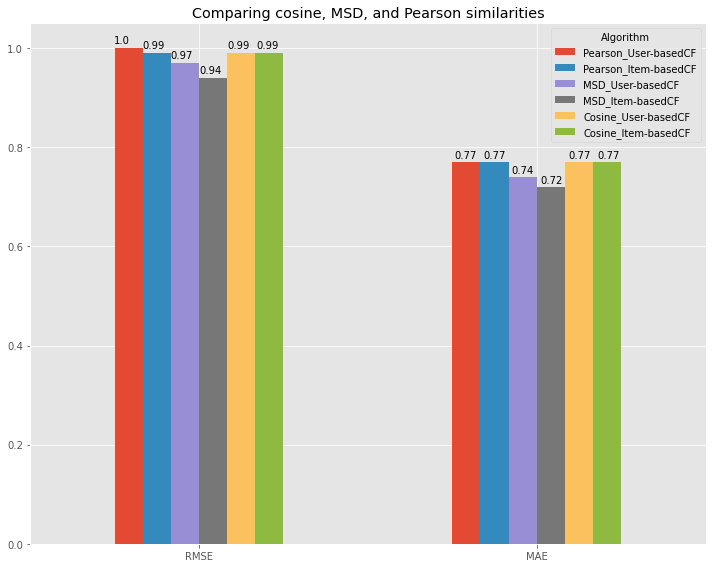

In [12]:

mpl.style.use('ggplot')
ax= benchmark_similarity[['test_rmse','test_mae']].rename(columns={'test_rmse':'RMSE', 'test_mae':'MAE'}).T.round(2).plot(kind='bar', figsize=(10, 8))
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.01, p.get_height() * 1.01))
plt.title('Comparing cosine, MSD, and Pearson similarities')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("Comparing similarities.png", dpi=250)
plt.show()

### Part f. 
Examining how the number of neighbors impacts the performances of User-based Collaborative Filtering and Item-based Collaborative Filtering?

**User-based Collaborative Filtering**

In [13]:
benchmark_usercf = []

for k in range(1,50):

    algorithm = KNNBasic(k, sim_options ={'name':'MSD','user_based': True})
    
    results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

    temp = pd.DataFrame.from_dict(results).mean(axis=0)

    benchmark_usercf.append(temp)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

**Item-based Collaborative Filtering**

In [14]:
benchmark_itemcf = []

for k in range(1,50):
    #{'user_based': False} for item-based
    algorithm = KNNBasic(k, sim_options = {'name':'MSD','user_based': False})
    
    results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)
    
    temp = pd.DataFrame.from_dict(results).mean(axis = 0)

    benchmark_itemcf.append(temp)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

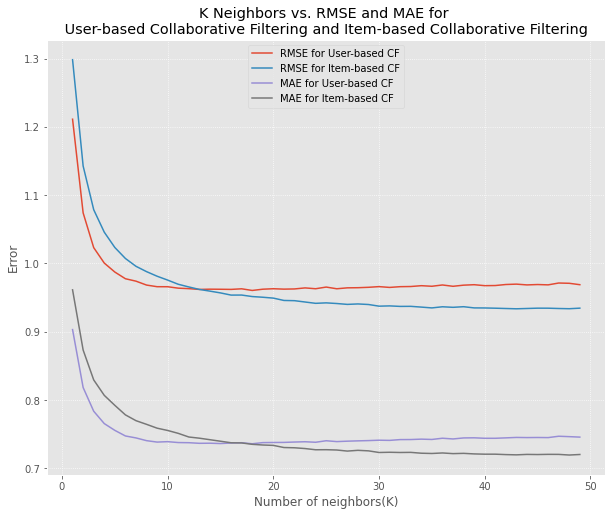

In [15]:
benchmark_user = pd.DataFrame(benchmark_usercf)
benchmark_item = pd.DataFrame(benchmark_itemcf)

user_rmse = benchmark_user['test_rmse']
item_rmse = benchmark_item['test_rmse']

user_mae = benchmark_user['test_mae']
item_mae = benchmark_item['test_mae']

#plotting K Neighbours vs RMSE and MAE
plt.figure(figsize=(10, 8))
plt.plot(range(1,50), user_rmse, label = "RMSE for User-based CF")
plt.plot(range(1,50), item_rmse, label = "RMSE for Item-based CF")
plt.plot(range(1,50), user_mae, label = "MAE for User-based CF")
plt.plot(range(1,50), item_mae, label = "MAE for Item-based CF")
plt.title('')
plt.xlabel('Number of neighbors(K)')
plt.ylabel('Error')

plt.title('K Neighbors vs. RMSE and MAE for \n User-based Collaborative Filtering and Item-based Collaborative Filtering ')
plt.legend(loc='upper center')
plt.grid(ls='dotted')
plot_colors = ['hotpink','darkviolet','mediumblue']

plt.savefig("KNvsRMSE&MAE.png", dpi=250)

plt.show()


### g. 
Identifying the best number of neighbor (denoted by K) for User/Item based collaborative filtering in terms of RMSE

In [16]:
print("For User-based CF, the best K =" , user_rmse.idxmin()+1, "with minimum RMSE =", min(user_rmse))
print("For Item-based CF, the best K =" , item_rmse.idxmin()+1 , "with minimum RMSE =", min(item_rmse))

For User-based CF, the best K = 18 with minimum RMSE = 0.9604252321189424
For Item-based CF, the best K = 43 with minimum RMSE = 0.9335727021270103
